In [2]:
import sys
import os
repo_dir = os.path.dirname(os.getcwd())
sys.path.append(repo_dir)

In [3]:
from models.cm import ContinuousMixture, GaussianDecoder
from torchvision.datasets import MNIST, FashionMNIST
from utils.reproducibility import seed_everything
from utils.datasets import UnsupervisedDataset
import torchvision.transforms as transforms
from models.nets import mnist_conv_decoder
from torch.utils.data import DataLoader
import numpy as np
import torch

device = 'cuda' if torch.cuda.is_available() else 'cpu'
gpus = None if device == 'cpu' else 1
print(device)

cuda


## Choose the dataset

In [4]:
# dataset, dataset_name = FashionMNIST, 'fashion_mnist'
dataset, dataset_name = MNIST, 'mnist'

In [5]:
transf = transforms.Compose([transforms.ToTensor()])
batch_size = 128

test = UnsupervisedDataset(dataset(root=repo_dir + '/data/', train=False, download=True, transform=transf))
test_loader = DataLoader(test, batch_size=batch_size)

## Load model (you should specify a path!)

In [12]:
# Warning: The model should be Conv based

path = '../logs/mnist_gaussian/FFM/latent_dim_16/num_bins_16384/version_1/checkpoints/best_model_valid-epoch=7.ckpt'
# path = '../logs/mnist_gaussian/denominator_1/FFM/latent_dim_16/num_bins_16384/lightning_logs/version_0/checkpoints/best_model_valid-epoch=12.ckpt'
model = ContinuousMixture.load_from_checkpoint(path).to(device)
model.missing = False
model.eval();

/home2/s3313093/venvs/my_env/lib/python3.10/site-packages/pytorch_lightning/utilities/parsing.py:208


## Compute LLs

In [13]:
# if you run OOM, you may want to use n_chunks
model.n_chunks = 32
n_bins_list = [2**7, 2**8, 2**9, 2**10, 2**11, 2**12, 2**13, 2**14]
            
for n_bins in n_bins_list:
    model.sampler.n_bins = n_bins
    z, log_w = model.sampler(seed=42)

    print('Computing test LL using %d bins..' % n_bins)
    print(model.eval_loader(test_loader, z, log_w, device=device).mean().item())

Computing test LL using 128 bins..


KeyboardInterrupt: 

## Sample from CMs

In [14]:
import matplotlib.pyplot as plt
import torchvision

In [15]:
latent_dim = model.sampler.latent_dim
samples = model.decoder.net(torch.randn(16, latent_dim).to(device)).detach().cpu()
print(samples.shape)
grid_img = torchvision.utils.make_grid(samples.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);

torch.Size([16, 2, 28, 28])


RuntimeError: shape '[16, 1, 28, 28]' is invalid for input of size 25088

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


tensor([[[[ 66.,  14.,  55.,  ..., 110.,  22.,  86.],
          [ 80., 114., 204.,  ..., 147.,  77.,   7.],
          [ 37., 182.,  22.,  ...,  55.,  41.,  35.],
          ...,
          [ 81., 141.,   5.,  ..., 190., 119., 144.],
          [ 41., 254.,  14.,  ...,  60.,  55., 228.],
          [  0., 143., 225.,  ...,   0.,   1.,   1.]]],


        [[[ 41., 113.,  84.,  ..., 164.,  64.,  75.],
          [ 16., 197., 132.,  ...,  91.,  83.,  10.],
          [ 41., 131.,  14.,  ...,  11., 130., 165.],
          ...,
          [ 63.,  39., 215.,  ...,  53., 252.,  21.],
          [ 65.,  24.,  22.,  ...,  25.,  41.,  87.],
          [  0.,   0.,   1.,  ...,   0.,   0.,   1.]]],


        [[[  3., 136.,  41.,  ...,   9., 112.,  16.],
          [140.,  93.,  10.,  ...,  66.,  38., 161.],
          [ 27.,  19., 168.,  ...,  30., 168., 147.],
          ...,
          [124., 196.,  88.,  ...,  97.,  50.,   1.],
          [ 55.,  69.,  84.,  ...,   0., 130., 202.],
          [251., 162.,  67., 

[Text(-20.0, 0, ''),
 Text(0.0, 0, ''),
 Text(20.0, 0, ''),
 Text(40.0, 0, ''),
 Text(60.0, 0, ''),
 Text(80.0, 0, ''),
 Text(100.0, 0, ''),
 Text(120.0, 0, ''),
 Text(140.0, 0, '')]

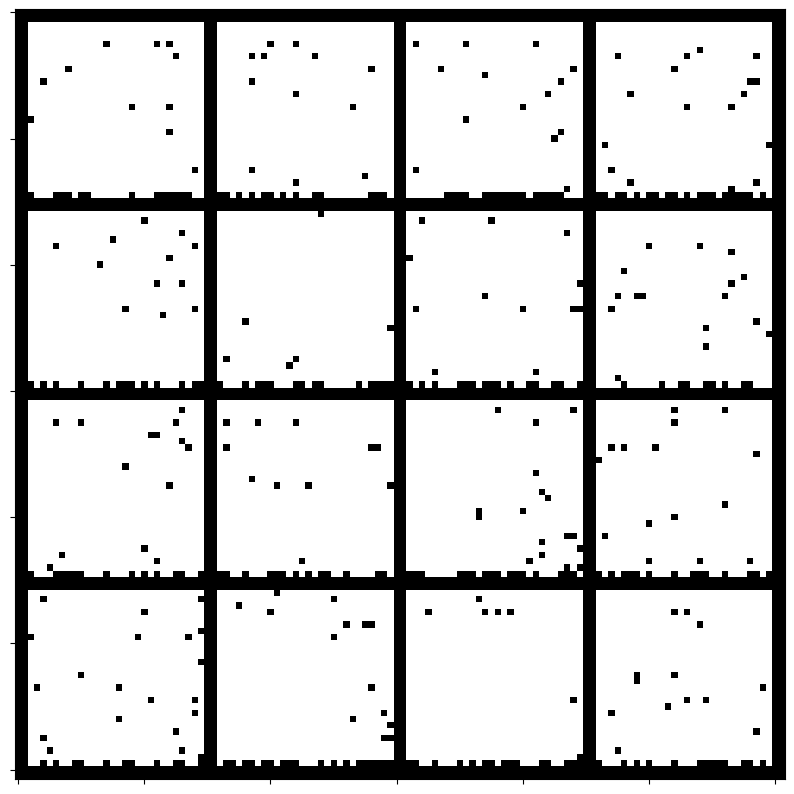

In [8]:
import torch.nn.functional as F

latent_dim = model.sampler.latent_dim
logits = model.decoder.net(torch.randn(16, latent_dim).to(device)).detach().cpu()  # [16, 256, 28, 28]

# Sample from the categorical distribution over 256 classes
probs = F.softmax(logits, dim=1)  # [16, 256, 28, 28]
samples = torch.multinomial(probs.permute(0, 2, 3, 1).reshape(-1, 256), num_samples=1)  # [16*28*28, 1]
samples = samples.view(16, 28, 28).unsqueeze(1).float() # normalize to [0,1] for visualization

print(samples)
# Plot
grid_img = torchvision.utils.make_grid(samples, nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0))
ax.set_yticklabels([])
ax.set_xticklabels([])


In [9]:
# tbd
from models.mixtures import CategoricalMixture

model.sampler.n_bins = n_components = 1024
z, log_w = model.sampler(seed=42)
mixture = CategoricalMixture(logits_p=model.decoder.net(z.to(device)), logits_w=log_w).to(device)

# return_p=False results in binary images, unsure why
samples = mixture.sample(16, return_p=False).detach().cpu()

grid_img = torchvision.utils.make_grid(samples.view(16, 1, 28, 28), nrow=4)
fig, ax = plt.subplots(1, figsize=(10, 10))
plt.imshow(grid_img.permute(1, 2, 0));
ax.set_yticklabels([]);
ax.set_xticklabels([]);

ImportError: cannot import name 'CategoricalMixture' from 'models.mixtures' (/scratch/s3313093/cm-tpm-main/models/mixtures.py)